# C-mean Clustering
Fuzzy c-Means Clustering} (FMC) is a clustering method which, unlike Hard k-Means Clustering, allows a data sample to more or less belong to one or more clusters. In this notebook, we will try to develop a semi-supervised C-mean Clustering.

## Loading the packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import operator
import math
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

PATH_TO_DATASET = '' # Not Given Yet 

%matplotlib inline

## The dataset
The following script allows you to create a 2D dataset by using the mouse. The fift first click adds points belonging to class A (blue), the 5th following click adds points belonging to class B (red) and the next click add unclassified points. You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {0,1,2} where 0 represent unclassified points.

<IPython.core.display.Javascript object>


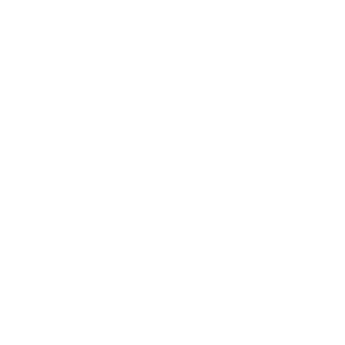

In [2]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
plt.title("Input Dataset")
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))

dataset = []

i = 0
def onclick(event):
    global dataset
    global i
    cx = event.xdata
    cy = event.ydata
    classe = 1 if(i<10) else 2 if(i<20) else 0
    i=i+1
    dataset.append((cx, cy, classe))

    plt.scatter(cx, cy, c=['k', 'b', 'r'][classe], s=100, lw=0)
    plt.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)


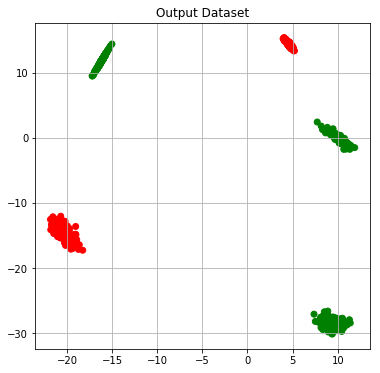

In [76]:
import numpy as np

def random_positive_semidefinite_matrix(d):
    Q = np.random.randn(d, d)
    eigvals = np.random.rand(d)
    return Q.T @ np.diag(eigvals) @ Q
    
    while True:
        A = np.random.rand(d, d)
        A += A.T
        if np.all(np.linalg.eigvals(A) > 0):
            return A

def make_spiral_clusters(c, cluster_size, n_noise, d=2):
    angle = np.linspace(0, 2*np.pi, c, endpoint=False)
    radius = np.linspace(10, 30, c)
    vx = np.cos(angle)*radius
    vy = np.sin(angle)*radius
    v = np.stack([vx, vy], axis=1)

    covariances = np.array([random_positive_semidefinite_matrix(d) for _ in range(c)])

    x = np.concatenate([np.random.multivariate_normal(v[i], covariances[i], cluster_size)
        for i in range(c)], axis=0)

    u = np.random.rand(n_noise, d)
    noise = np.min(x, axis=0)*u + (1 - u)*np.max(x, axis=0)

    x = np.concatenate([x, noise], axis=0)

    return x, v


dataset, true_centers = make_spiral_clusters(5, 150, 0)

labels = [1]*int(len(dataset)/5) + [2]*int(len(dataset)/5) + [1]*int(len(dataset)/5) + [2]*int(len(dataset)/5)+ [1]*int(len(dataset)/5)
labelzzz = copy.copy(labels)
labels_names = np.unique(labelzzz)

fig2 = plt.figure(figsize=(6,6))
plt.title("Output Dataset")

plt.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])[int(label)] for label in labels])
plt.grid()
plt.show()
for i in range(100):
    labels[np.random.randint(len(labels))] = 0



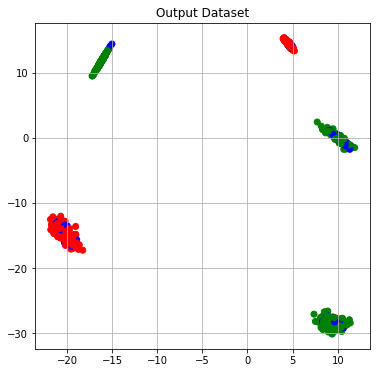

[[  9.31205184   0.40822976   0.        ]
 [ 10.91657435  -1.74600604   1.        ]
 [ 10.01703019   0.37228399   0.        ]
 ...
 [  8.59462444 -28.1770892    1.        ]
 [  9.60541274 -27.60845897   1.        ]
 [  8.57315394 -29.08428771   1.        ]]


In [77]:
dataset = np.array(dataset)
labels = np.expand_dims(labels, axis=1)
dataset = np.append(dataset, labels, axis=1)
fig2 = plt.figure(figsize=(6,6))
plt.title("Output Dataset")

plt.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])[int(label)] for label in labels])
plt.grid()
plt.show()
print(dataset)

## Membership Matrix
The Membership matrix lists all the data samples membership grades to a particular cluster. Here we first randomly initialize it.

In [7]:
def initializeMembershipMatrix(dataset, k):
    membership_mat = list()
    for i in range(len(dataset)):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

## Cluster Center
Here we calculate each cluster center depending on the membership grades.

In [8]:
def calculateClusterCenter(dataset, membership_mat, k, fuzzy_param):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = list()
    for j in range(k):
        x = cluster_mem_val[j]
        xraised = [e ** fuzzy_param for e in x]
        denominator = sum(xraised)
        temp_num = list()
        for i in range(len(dataset)):
            data_point = dataset[i]
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

## Semi-supervised C-Mean

In [9]:
def evalConvergence(mb, previous_mb, threshold):
    return (np.absolute(np.array(mb) - np.array(previous_mb))).max() < threshold
        

In [10]:
def initializeMembershipMatrixSupervised(dataset, k):
    membership_mat_supervised = list()
    for i in range(len(dataset)):
        if (dataset[i][2] == 0):
            random_num_list = [0 for i in range(k)]
        else:
            random_num_list = [1 if((i+1)==dataset[i][2]) else 0 for i in range(k)]
        
        membership_mat_supervised.append(random_num_list)
    return membership_mat_supervised

In [11]:
def evalAccuracy(dataset, k):
    pass

In [12]:
def calculateClusterCenterSup(dataset, membership_mat, membership_mat_sup,  k, fuzzy_param):
    cluster_centers = []
    for i in range(k):
        for n in range(len(dataset)):
            denum = abs(membership_mat[n][i] - membership_mat_sup[n][i]) ** fuzzy_param
            num = denum*dataset[n]#dataset[n, :-1] ? 
        cluster_centers.append(num/denum)
    return cluster_centers

In [13]:
def updateMembershipValueSup(dataset, membership_mat, membership_mat_sup, cluster_centers, fuzzy_param, k):
    def d(n, c):
        return np.linalg.norm(list(map(operator.sub, dataset[n], cluster_centers[c])))** 2
    p = 1/(fuzzy_param- 1)
    
    for i in range(k):
        for n in range(len(dataset)):  
            membership_mat[n][i] = membership_mat_sup[n][i] + (1 - np.sum(membership_mat_sup[n])) * d(n, i) ** p / np.sum([d(n,j) for j in range(k)])
    return membership_mat

In [32]:
import numpy as np
import scipy.spatial
import copy

def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def calculate_covariances(x, u, v, m):
    c, n = np.array(u).shape
    d = np.array(v).shape[1]
    
    um = np.array(u)**m

    covariances = np.zeros((c, d, d))

    for i in range(c):
        xv = x - v[i]
        uxv = um[i, :, np.newaxis]*xv
        covariances[i] = np.einsum('ni,nj->ij', uxv, xv)/np.sum(um[i])
    
    return covariances

# Partition Coefficient
def pc(x, u, v, m):
    c, n = np.array(u).shape
    return np.square(np.array(u)).sum()/n

# Fuzzy Hyperbolic Volume
def fhv(x, u, v, m):
    covariances = calculate_covariances(x, u, v, m)
    return sum(np.sqrt(np.linalg.det(cov)) for cov in covariances)

# Xie-Beni Index
def xb(x, u, v, m):
    n = np.array(x).shape[0]
    c = np.array(v).shape[0]

    um = np.array(u)**m
    
    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)
    
    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def checkKnownEntriesBetter(dataset, labels, c):
    res = np.zeros((c, 2))
    for cluster in range(c) :
        for i in range(len(dataset)):
            if(dataset[i][-1] != 0 and labels[i] == cluster):
                res[cluster][int(dataset[i][-1] - 1)] += 1
        print('res', res)
   # print("res1", res)
    
    for cluster in range(c):
        c_total = res[cluster][0] + res[cluster][1]
        res[cluster][0] /= c_total
        res[cluster][1] /= c_total

  #  print("res2", res)
    return res
    

def checkKnownEntries(x, labels, c):
    
    # 4 columns for each cluster :
    # |# class0 |# class1 | %0 | %1 |
    min_c = min(labels)
    res = [[0 for i in range(4)] for j in range(c)]
    for i in range(len(x)):
        # If the class is known (i.e. not 0)
        if(x[i][-1]!= 0):
            print(str(x[i][-1]))
            res[labels[i] - min_c][int(x[i][-1])-1] = res[labels[i] - min_c][int(x[i][-1])] + 1
            
    for i in range(c):
        if((res[i][0] + res[i][1]) != 0 and (res[i][0] + res[i][1]) != 0):
            res[i][2] = res[i][0] / (res[i][0] + res[i][1])        
            res[i][3] = res[i][1] / (res[i][0] + res[i][1])
        else :
            res[i][2] = 0.5
            res[i][3] = 0.5
    #print(res)
        
    return res


In [15]:
import numpy as np
from cvi import *

def fcm_get_u(x, v, m):
    distances = pairwise_squared_distances(x, v)
    nonzero_distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = np.reciprocal(nonzero_distances)**(1/(m - 1))
    return inv_distances.T/np.sum(inv_distances, axis=1)

def fcm(x, c, m=2.0, v=None, max_iter=100, error=0.05):
    if v is None: v = x[np.random.randint(x.shape[0], size=c)]
    u = fcm_get_u(x, v, m)
 #   print('fcm', len(u))

    for iteration in range(max_iter):
        u_old = u
        um = u**m
        v = np.dot(um, x)/np.sum(um, axis=1, keepdims=True)
        u = fcm_get_u(x, v, m)
        if np.linalg.norm(u - u_old) < error: break
    return u, v

In [31]:
def getClass(dataset, labels, k):
    count_class = np.zeros((k, len(labels_names)))
    newLabels = copy.copy(labels)

    for i in range(len(dataset)):
        if(dataset[i][-1] != 0):
            count_class[labels[i]][int(dataset[i][-1] - 1)] += 1

    for c in range(len(count_class)):  
        indexPredominantClass = np.argmax(count_class[c])
        if np.max(count_class[c]) == 0:
            cl = 0
        else :
            cl = labels_names[indexPredominantClass]
            
        for i in range(len(labels)):
            if labels[i] == c:
                newLabels[i] = cl 
            
    return newLabels
    

def extractCluster(c, dataset, labels):
#    print('Good cluster :', c)
 #   print('dataset', dataset)
    cluster = np.empty((0, len(dataset[0])), float)
    indices = []
    for i in range(len(dataset)):
        if(labels[i] == c):
            cluster = np.vstack((cluster, dataset[i]))
            indices.append(i)
#    print('Cluster', cluster)
    return cluster, indices
    

In [20]:
def getAccuracy(true_labels, labels):
  #  print(labels)
  #  print(true_labels)
    same = 0
    for t, p in zip(true_labels, labels):
        if int(t) == int(p):
            same += 1
    return same / len(true_labels) * 100



## Main Execution 
blablabla

res [[255. 133.]
 [  0.   0.]]
res [[255. 133.]
 [137. 133.]]
[[0.65721649 0.34278351]
 [0.50740741 0.49259259]]
res [[255. 133.]
 [  0.   0.]
 [  0.   0.]]
res [[255. 133.]
 [  0. 133.]
 [  0.   0.]]
res [[255. 133.]
 [  0. 133.]
 [137.   0.]]
[[0.65721649 0.34278351]
 [0.         1.        ]
 [1.         0.        ]]
res [[255. 133.]
 [  0.   0.]]
res [[255. 133.]
 [137.   0.]]
[[0.65721649 0.34278351]
 [1.         0.        ]]
res [[130. 133.]
 [  0.   0.]]
res [[130. 133.]
 [125.   0.]]
[[0.49429658 0.50570342]
 [1.         0.        ]]
res [[  0. 133.]
 [  0.   0.]]
res [[  0. 133.]
 [130.   0.]]
[[0. 1.]
 [1. 0.]]
coucou labels 450
coucou labels 750
centers [[-1.94756400e+01 -1.11417450e+01]
 [ 9.33444620e+00 -2.75987817e+01]
 [ 9.39423312e+00 -2.63014581e+01]
 [-1.56488521e+01  1.17938960e+01]
 [ 4.63104031e+00  1.43560668e+01]
 [ 1.02146568e+01  1.51707986e-02]]


<IPython.core.display.Javascript object>


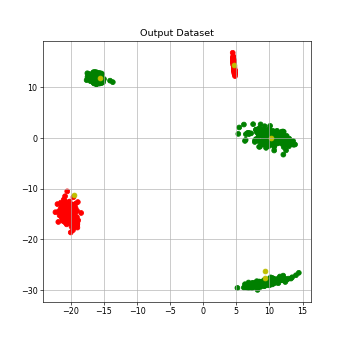

res [[137. 133.]
 [  0.   0.]]
res [[137. 133.]
 [255. 133.]]
[[0.50740741 0.49259259]
 [0.65721649 0.34278351]]
res [[137.   0.]
 [  0.   0.]
 [  0.   0.]]
res [[137.   0.]
 [  0. 133.]
 [  0.   0.]]
res [[137.   0.]
 [  0. 133.]
 [255. 133.]]
[[1.         0.        ]
 [0.         1.        ]
 [0.65721649 0.34278351]]
res [[130. 133.]
 [  0.   0.]]
res [[130. 133.]
 [125.   0.]]
[[0.49429658 0.50570342]
 [1.         0.        ]]
res [[130.   0.]
 [  0.   0.]]
res [[130.   0.]
 [  0. 133.]]
[[1. 0.]
 [0. 1.]]
coucou labels 450
coucou labels 750
accuracy =  100.0


In [37]:
def updateMembershipValue(dataset, membership_mat, cluster_centers, fuzzy_param, k):
    p = float(2/(fuzzy_param-1))
    for i in range(len(dataset)):
        x = dataset[i]
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat


def getClusters(dataset, membership_mat):
 #   print("Len  data", len(dataset))

    cluster_labels = list()
#    print((membership_mat))
    for i in range(len(dataset)):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels


def fuzzyCMeansClustering(dataset, k = 2, threshold = 0.1, fuzzy_param = 2.00, maxSteps = 100000):
    # Membership Matrix
    membership_mat = initializeMembershipMatrix(dataset, k)
    previous_mb = None
    steps = 0
    
    while previous_mb is None or not evalConvergence(membership_mat, previous_mb, threshold) or steps >= maxSteps:
        cluster_centers = calculateClusterCenter(dataset[:,:-1], membership_mat, k, fuzzy_param)
        membership_mat = updateMembershipValue(dataset[:,:-1], membership_mat, cluster_centers, fuzzy_param, k)
        cluster_labels = getClusters(dataset[:,:-1], membership_mat)
        previous_mb = membership_mat
        steps += 1
    return cluster_labels, cluster_centers, membership_mat

def flatten(l):
    try:
        return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
    except IndexError:
        return []

def clusterize(dataset):
    result_labels = np.zeros((len(dataset), len(dataset[0])), float)
    res_labels = []

#    result_mb     = [[]]
    result_centers   = []
    temp_data     = copy.copy(dataset)
    found_clusters = 0
    result_index = 0
    c = 2
    done = False
    while(not done and c < math.sqrt(len(dataset))): 
        #labels, centers, mb = fuzzyCMeansClustering(temp_data, k = c)
        mb, centers = fcm(temp_data[:,:-1], c)
        mb_t = mb.T
   #     print('mb', mb)
        labels = getClusters(temp_data[:,:-1], mb_t)
        # First, check supervised values
        # TOFIX : Bordel with cluster indexes, won't work.
        sup_verif = checkKnownEntriesBetter(temp_data, labels, c)
        print(sup_verif)
        all_zeros = 1
        for val in sup_verif:
            for v in val :
                if(v != 0):
                    all_zeros = 0
     #   print("verif: ", sup_verif)
        cluster_ok = []
        for i in range(c):
            if(sup_verif[i][0] < 0.1 or sup_verif[i][0] > 0.90):
                cluster_ok.append(i)
  #      print('cluster ok ', cluster_ok)
  #      print('len cluster_ok', len(cluster_ok))
  #      print(sup_verif)
  #      print("Len remaining data", len(temp_data))

        if(len(cluster_ok) == 0):
            c =c + 1
        elif(len(cluster_ok) == c or all_zeros == 1):
            print('coucou labels', len(res_labels))
            done = 1
            for i in range(len(temp_data)):
                    result_labels[result_index] = temp_data[i]
                    res_labels.append(int(found_clusters + labels[i]))
                    result_index += 1
            for i in range(len(centers)):
                result_centers += [centers[i]]
            print('coucou labels', len(res_labels))
        else:
            # Check our values aren't just luckily in same clusters using unsup CVI
           
            for c in cluster_ok :
                cluster, indices = extractCluster(c, temp_data, labels)
         #       print(len(result_labels))
        #        print(len(cluster))
                for i in range(len(cluster)):
                    result_labels[result_index] = cluster[i]
                    res_labels.append(int(found_clusters))
                    result_index += 1
       #         print('indices', indices)
     #          result_mb.append([])
      #          for i in indices:
      #              result_mb[found_clusters].append([mb_t[i]])
                result_centers += [centers[int(c)]]
             #   result_labels = np.append(result_labels[found_clusters], cluster)
             #   result_labels = np.reshape(result_labels[found_clusters],(len(result_labels)/3, 3))
                temp_data = np.delete(temp_data, indices, 0)
        #        print('result',result_labels)
                found_clusters += 1
            c = c - len(cluster_ok) + 2
            if (c < 2):
                c = 2
            continue
    result_centers = np.array(result_centers)
    return res_labels, result_centers

labels, centers = clusterize(dataset)
print('centers', centers)

labels = getClass(dataset, labels, len(centers))
#labels, centers, mb = fuzzyCMeansClustering(dataset, k=2)

#mb, centers = fcm(dataset[:,:-1], 4)
#print(len(mb))
#print(len(mb[0]))

#labels = getClusters(dataset[:,:-1], mb.T )
#print(len(labels))
#print(len(dataset))
#print(mb)

#centers = np.array(centers)
# Visualize the test data

fig2 = plt.figure(figsize=(6,6))
plt.title("Output Dataset")
plt.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])[int(label)] for label in labels])
plt.scatter(centers[:,0], centers[:,1], c='y')
plt.grid()
plt.show()
labels, centers = clusterize(dataset)
labels = getClass(dataset, labels, len(centers))
#print("label:", labels, len(labels))
print("accuracy = ", getAccuracy(labelzzz, labels))


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
conf_mat = metrics.confusion_matrix(labels, true_labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names))
    plt.xticks(tick_marks, labels_names, rotation=45)
    plt.yticks(tick_marks, labels_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plot_confusion_matrix(conf_mat)

## Results and Analyse

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
conf_mat = confusion_matrix(labels, true_labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names))
    plt.xticks(tick_marks, labels_names, rotation=45)
    plt.yticks(tick_marks, labels_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plot_confusion_matrix(conf_mat)

In [ ]:
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)